In [71]:
import pickle
import pandas as pd
import os
import AmazonScraper



import numpy as np
from scipy import stats
import pandas as pd
from subprocess import call
from scipy.stats import binom, norm


import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import bisect
import diagnostic_plots


import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors.kde import KernelDensity
from sklearn.linear_model import RidgeCV, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline


from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

from sklearn.model_selection import learning_curve

    
import warnings
warnings.filterwarnings('ignore')

In [72]:
def get_polynomial_features(degree, x_values):
    return PolynomialFeatures(degree=degree).fit_transform(x_values)


def MSE(a,b):
    try:
        a=a.values
    except(AttributeError):
        pass
    try:
        b=b.values
    except(AttributeError):
        pass
    try:
        res=(sum([(a[i]-b[i])**2 for i in range(len(a))])/len(a))[0]
        return res
    except:
        return (sum([(a[i]-b[i])**2 for i in range(len(a))])/len(a))
    
    

def R2(a,b):
    try:
        a=a.values
    except(AttributeError):
        pass
    try:
        b=b.values
    except(AttributeError):
        pass
    mean_pred=[np.mean(b) for i in range(len(b))]
    return 1-MSE(a,b)/MSE(mean_pred,b)


def make_vals(a, n):
    a=sorted(a)
    big=max(a)
    small=min(a)
    spacing=np.linspace(small,big,n)
    vals=[]
    N=len(a)
    for i in spacing:
        vals.append(len([x for x in a if x<i])/N)
    return [vals, small, big, n]


al=[10**(float(i)/10) for i in np.arange(-100,10,1)]
def get_model_stats(X_train,y_train,model,max_degree=7,cv=4,alphas=al):
    results=[]
    for deg in range(1,max_degree+1):
        pipeline=make_pipeline(StandardScaler(),PolynomialFeatures(deg),model)
        #pipeline=make_pipeline(PolynomialFeatures(deg),model)
        fit=pipeline.fit(X_train, y_train)
        y_predict=fit.predict(X_train)
        naive_score=fit.score(X_train,y_train)
        scores = cross_val_score(fit, X_train, y_train, cv=cv, scoring='mean_squared_error')
        cross_val=np.mean(scores)
        features=X_train.shape[1]-1
        mse_adj=R2_adj(y_predict,y_train,features)
        results.append([deg,naive_score,cross_val,mse_adj])
        print(f"Degree: {deg},   Naive Score: {round(naive_score,3)},  Cross_Val: {round(cross_val,2)},   MSE: {round(mse_adj,3)}")
    return results






def make_cdf(valset,y):
    big=valset[2]
    small=valset[1]
    spacing=np.linspace(small,big,valset[3])

    if (y<small) or y==small:
        return 0
    elif y>big or y==big:
        return 1
    else:
        index=bisect.bisect(spacing,y)
        return vals[0][index]


    
def make_ppf(a,perc):
    a=sorted(a)
    N=len(a)
    index=int(N*perc)
    if perc==1 or perc>1:
        return max(a)
    elif perc==0 or perc<0:
        return min(a)
    else:
        return a[index]

def R2_adj(a,b,p):
    n=len(a)
    return (R2(a,b)-1)*(n-1)/(n-1-p)+1

def square(x):
    return x**2



def build_df():
    test=1
    x=100
    data=[]
    while test:
        name=f'cache/cache_{x}.pkl'
        try:
            with open(name,'rb') as pkl:
                data_temp=pickle.load(pkl)
            data+=data_temp
            x+=100
        except:
            test=0
            return pd.DataFrame(data,columns=['url','stars','pics','descriptors','desLength','price'])

        
def fix_row(row):
    return [float(x) for x in list(row)]


def clean_df():
    df=build_df()
    clean1=df.dropna().drop(columns=['url'])
    clean2=[]
    for i in range(clean1.shape[0]):
        try:
            clean_row=[fix_row(clean1.iloc[i])]
            clean2+=clean_row
        except:
            pass
    return pd.DataFrame(clean2,columns=['stars','pics','descriptors','desLength','price'])

#display(HTML("<style>.container {width:95% !imortant;}</style?"))



# Strategy

Our plan is as follows:

1. Load dataset, perform train-test-split.
2. Develop baseline model.
3. Other Models
    1. Polynomial Features
    2. Lasso
    3. Ridge
    4. Log transform target
    5. Boxcox transform
    6. Transform to gaussian
    7. Dropping high leverage points
    8. Random Forest
    9. Gradient boosting.
4. Open test data. 

There are many other possible models to explore and we have not been systematic.  For each model we use 4-fold cross validation in order to determine the best parameters of the model.  

In [73]:
df=clean_df()
df=df[df.price<30]
df.shape

(5336, 5)

In [7]:
df.head()

,stars,pics,descriptors,desLength,price
0,2.9,12.0,5.0,117.0,4.99
1,3.1,15.0,5.0,180.0,7.99
2,5.0,12.0,5.0,168.0,10.99
3,4.2,11.0,4.0,135.0,5.95
4,5.0,15.0,5.0,154.0,14.99


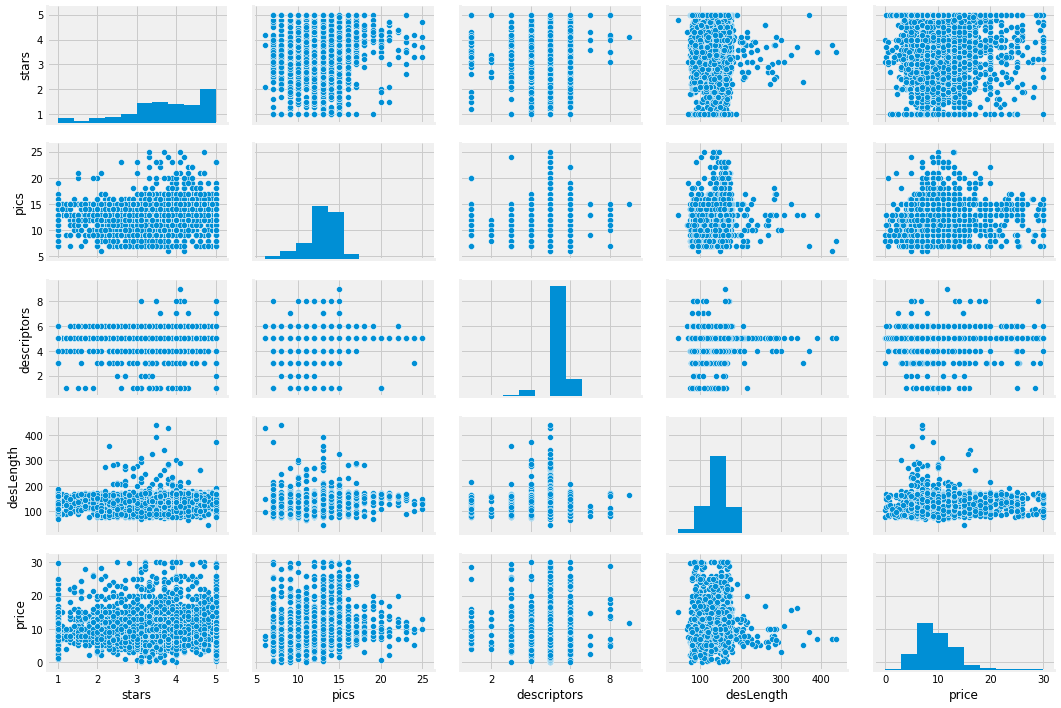

In [98]:
sns.pairplot(df, size = 2, aspect=1.5);

## Train-Test Split

As a first step, we're going to split the data into a training set and a test set.  All of the work will be done on the training set.  We'll only access the test set at the very end.

In [5]:
x=df.iloc[:,:4]
y=df.iloc[:,4:5]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)
df_train=pd.DataFrame(X_train,columns=df.columns)
df_train['price']=y_train

## Baseline Model

Let's take as our baseline model a linear regression model using the features 'stars', 'pics', 'descriptors' and 'desLength', together with their squares.  For convenience, we'll name the squared variables at this stage.

In [6]:
df_train['pics_squared']=df_train['pics'].apply(square)
df_train['desLength_squared']=df_train['desLength'].apply(square)
df_train['descriptors_squared']=df_train['descriptors'].apply(square)
df_train['stars_squared']=df_train['stars'].apply(square)

y_baseline, X_baseline = patsy.dmatrices('price ~ desLength+descriptors+stars+pics +\
 pics_squared+desLength_squared+descriptors_squared', data=df_train, return_type="dataframe")

#y_baseline, X_baseline = patsy.dmatrices('price ~ desLength+descriptors+stars+pics', data=df, return_type="dataframe")

# Create your model
model_baseline = sm.OLS(y_baseline,X_baseline)
# Fit your model to your training set
fit_baseline = model_baseline.fit()
# Print summary statistics of the model's performance
fit_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     23.14
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           5.03e-31
Time:                        06:51:22   Log-Likelihood:                -12149.
No. Observations:                4268   AIC:                         2.431e+04
Df Residuals:                    4260   BIC:                         2.437e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.5061      1.491      1.681      0.093      -0.416       5.428
desLength               0.0457      0.009      5.000      0.000       0.028       0.064
descriptors            -0.9269      0.433     -2.142      0.032      -1.775      -0.078
stars                   0.1881      0.063      2.998      0.003       0.065       0.311
pics                    0.6299      0.170      3.709      0.000       0.297       0.963
pics_squared           -0.0149      0.006     -2.317      0.021      -0.027      -0.002
desLength_squared      -0.0001   3.01e-05     -4.155      0.000      -0.000   -6.61e-05
descriptors_squared     0.0878      0.048      1.832      0.067      -0.006       0.182
==============================================================================
Omnibus:                     1315.044   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4560.733
Skew:                           1.530   Prob(JB):                         0.00
Kurtosis:                       7.035   Cond. No.                     5.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
X_baseline.head()

,Intercept,desLength,descriptors,stars,pics,pics_squared,desLength_squared,descriptors_squared
2991,1.0,160.0,5.0,4.2,16.0,256.0,25600.0,25.0
1748,1.0,169.0,5.0,5.0,13.0,169.0,28561.0,25.0
4700,1.0,153.0,5.0,2.6,15.0,225.0,23409.0,25.0
2242,1.0,159.0,5.0,4.2,15.0,225.0,25281.0,25.0
2831,1.0,77.0,5.0,4.1,17.0,289.0,5929.0,25.0


In [179]:
X_test['one']=[1 for _ in range(len(X_test))]
#X_test['stars_squared']=X_test['stars'].apply(square)
X_test['descriptors_squared']=X_test['descriptors'].apply(square)
X_test['desLength_squared']=X_test['desLength'].apply(square)
X_test['pics_squared']=X_test['pics'].apply(square)

In [181]:
#X_test=X_test.drop('stars_squared',axis=1)
X_test.head()

,stars,pics,descriptors,desLength,descriptors_squared,desLength_squared,pics_squared,one
1171,5.0,13.0,4.0,143.0,16.0,20449.0,169.0,1
1881,4.8,12.0,5.0,89.0,25.0,7921.0,144.0,1
3123,4.4,13.0,6.0,124.0,36.0,15376.0,169.0,1
815,3.9,11.0,6.0,163.0,36.0,26569.0,121.0,1
169,3.9,17.0,5.0,162.0,25.0,26244.0,289.0,1


In [182]:
y_test_baseline=fit_baseline.predict(X_test)

In [188]:
R2_adj(y_test,y_test_baseline,7)

-2.9775559681543147

In [187]:
np.mean(cross_val_score(LinearRegression(),X_baseline,y_baseline,cv=4,scoring="mean_squared_error"))

-17.46654450998825

# Untransformed Data

## Model I: Linear Regression + Polynomial Features

The only difference between this and the baseline model is that we will consider higher order polynomials and allow for interaction terms.  

In [75]:
model1=LinearRegression()

results1=get_model_stats(X_train,y_train,model1,7)

NameError: name 'luther' is not defined

So, apparently, the quadratic model wins after cross-validation.  We also beat our baseline with a score of .04.

In [119]:
xt2=X_train.drop(['y'],axis=1)

In [122]:
quad_lr=make_pipeline(PolynomialFeatures(),LinearRegression(2))
quad_lr.fit(xt2,y_train)
y_test_predict=quad_lr.predict(X_test)
R2_adj(y_test_predict,y_test,4)

0.01392290320551215

In [74]:
fit=model1.fit(X_train,y_train)
X_train_proxy=X_train
X_train_proxy['y']=y_train
X_train_proxy=X_train_proxy.dropna()
diagnostic_plots.diagnostic_plots(X_train_proxy.drop('y',axis=1),X_train_proxy['y'],model_fit=fit_baseline)

NameError: name 'model1' is not defined

### Learning Curve

In [76]:
from sklearn.svm import SVC
quad_features = PolynomialFeatures(2)
X_quad=quad_features.fit_transform(X_train.values)
model = LinearRegression()


#fix_row(y_train.values)
#outputs three arrays:
# amount of data used per test, 
# training scores (one row per test, one column per group),
# test scores (one row per test, one column per group)
learning_curve(model, X_quad, fix_row(y_train.values), train_sizes=[50, 80, 110,1000,2000], cv=5);

In [77]:
train_sizes, train_scores, test_scores = learning_curve(model, X_quad, y_train, cv= 4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)
learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df

,train_size,train_score,test_score
0,320,0.089554,-0.045391
1,1040,0.047429,0.021441
2,1760,0.042654,0.020719
3,2480,0.038213,0.030129
4,3201,0.042607,0.031132


(-1, 1)

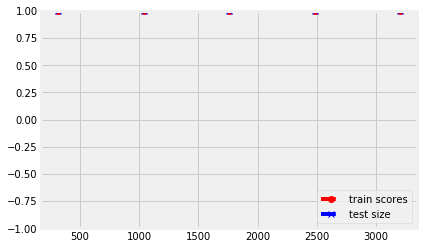

In [63]:
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

## Model II: Ridge with Polynomial Features.

The ridge model takes an additional parameter, $\alpha$, which determines how much weight to give to the L2-norm regulator term.  The RidgeCV module allows us to easily scan over a set of alphas and then returns the best model with the best alpha.

In [23]:
alphas=[10**(float(i)/10) for i in np.arange(-100,10,1)]
model2=RidgeCV(cv=4,alphas=alphas)
results2=get_model_stats(X_train,y_train,model2,7)

Degree: 1,   Naive Score: 0.03,  Cross_Val: -17.55,   MSE: 0.03
Degree: 2,   Naive Score: 0.041,  Cross_Val: -17.47,   MSE: 0.041
Degree: 3,   Naive Score: 0.053,  Cross_Val: -17.6,   MSE: 0.053
Degree: 4,   Naive Score: 0.068,  Cross_Val: -18.61,   MSE: 0.067
Degree: 5,   Naive Score: 0.092,  Cross_Val: -55.99,   MSE: 0.092
Degree: 6,   Naive Score: 0.12,  Cross_Val: -1532.99,   MSE: 0.119
Degree: 7,   Naive Score: 0.16,  Cross_Val: -222145.39,   MSE: 0.16


Note that the adjusted mean squared error doesn't improve relative to our previous model.

In [126]:
ridge_score=[]
for alpha in alphas:
    ridge=make_pipeline(PolynomialFeatures(2),RidgeCV(cv=4,alphas=[alpha]))
    ridge.fit(xt2,y_train)
    y_predict=ridge.predict(X_test)
    y_test_p=ridge.predict(X_test)
    score=np.mean(cross_val_score(ridge,xt2,y_train,cv=4,scoring='mean_squared_error'))
    ridge_score.append([alpha,score,R2_adj(y_test_p,y_test,4)])
#y_test_predict=quad_lr.predict(X_test)
#R2_adj(y_test_predict,y_test,4)

In [132]:
sorted(ridge_score, key = lambda x: x[1])[::-1];


## Model III: Lasso with polynomial features.

In [14]:
alphas=[10**(float(i)/10) for i in np.arange(-100,10,1)]
model3=LassoCV(cv=4,alphas=alphas)
results3=get_model_stats(X_train,y_train,model3,7)

Degree: 1,   Naive Score: 0.03,  Cross_Val: -17.55,   MSE: 0.03
Degree: 2,   Naive Score: 0.04,  Cross_Val: -17.44,   MSE: 0.04
Degree: 3,   Naive Score: 0.049,  Cross_Val: -17.47,   MSE: 0.049
Degree: 4,   Naive Score: 0.05,  Cross_Val: -18.12,   MSE: 0.049
Degree: 5,   Naive Score: 0.001,  Cross_Val: -19.63,   MSE: -0.0
Degree: 6,   Naive Score: 0.021,  Cross_Val: -28.1,   MSE: 0.02
Degree: 7,   Naive Score: 0.023,  Cross_Val: -977.29,   MSE: 0.022


In [51]:
alphas2=[10**(float(i)/10) for i in np.arange(-200,-50,1)]
acc=[]
for a in alphas2:
    bm=Lasso(alpha=[a])
    poly=PolynomialFeatures(2)
    X3=poly.fit_transform(X_train)
    X3_test=poly.fit_transform(X_test)
    fit_bm=bm.fit(X3,y_train)
    y_test_predict=fit_bm.predict(X3_test)
    y_train_predict=fit_bm.predict(X3)
    yt_fix=[y_train.values[i][0] for i in range(len(y_train))]
    ytest_fix=[x[0] for x in y_test.values]
    z=[yt_fix[i]-y_train_predict[i] for i in range(len(y_train))]
    r2a_test=R2_adj(y_test_predict,ytest_fix,14)
    r2a_train=R2_adj(y_train_predict,fix_row(y_train.values),14)
    acc.append([r2a_test,r2a_train])
#z=y_train-y_train_predict

In [54]:
np.mean([x[0] for x in acc])

0.004559685121028739

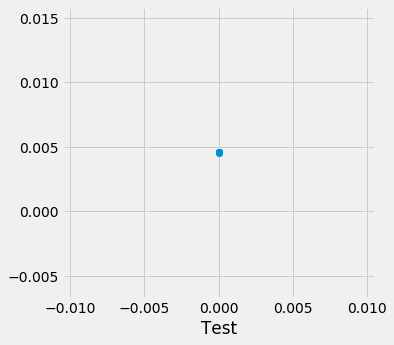

In [52]:
plt.scatter(alphas2,[x[0] for x in acc])
plt.xlabel("Test")
plt.show()

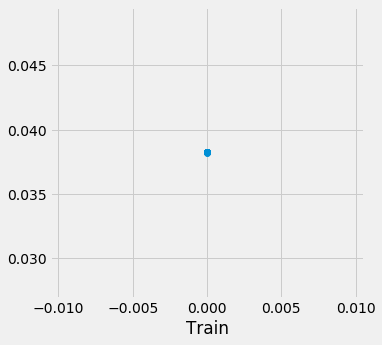

In [53]:
plt.scatter(alphas2,[x[1] for x in acc])
plt.xlabel("Train")
plt.show()

In [16]:
#z=y_train.values-y_train_predict
#plt.plot(z,y_train_predict)
#plt.title("Residual Plot")
#plt.xlabel("Actual Values")
#plt.ylabel("Residuals")
#plt.show()
#fix_row(y_train.values)
yt_fix=[y_train.values[i][0] for i in range(len(y_train))]

In [17]:
z=[y_train.values[i][0]-y_train_predict[i] for i in range(len(y_train))]

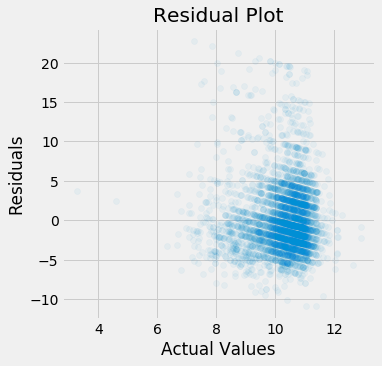

In [10]:
plt.scatter(y_train_predict,z,alpha=.05)
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()

In [19]:
R2_adj(fix_row(y_test.values),y_test_predict,14)

-17.09245372238712

# Transformed Data

## Model IV: Log transform of price.

Now, let's repeat the excercise with log-price.  First, we predict the log values and then we compute scores with the exponentiated values.

In [142]:
results4=[]
for i in range(1,8):
    degree=i
    est = make_pipeline(StandardScaler(),PolynomialFeatures(degree), LinearRegression())
    log_y_train=np.log(y_train)
    fit4=est.fit(X_train, log_y_train)
    scores = cross_val_score(fit4, X_train, log_y_train, cv=4, scoring='mean_squared_error')
    log_y_predict=fit4.predict(X_train)
    mse_adj=round(R2_adj(np.exp(log_y_predict),np.exp(log_y_train),4),3)
    results4.append([i,round(fit4.score(X_train,log_y_train),3),round(np.mean(scores),2),mse_adj])
    print(f"Degree: {i},   Naive Score: {round(fit4.score(X_train,log_y_train),3)},  Cross_Val: {round(np.mean(scores),3)},   Adj R2: {mse_adj}")
    

Degree: 1,   Naive Score: 0.058,  Cross_Val: -0.2,   Adj R2: -0.015
Degree: 2,   Naive Score: 0.078,  Cross_Val: -0.197,   Adj R2: 0.002
Degree: 3,   Naive Score: 0.086,  Cross_Val: -0.199,   Adj R2: 0.011
Degree: 4,   Naive Score: 0.103,  Cross_Val: -0.226,   Adj R2: 0.026
Degree: 5,   Naive Score: 0.129,  Cross_Val: -0.659,   Adj R2: 0.051
Degree: 6,   Naive Score: 0.162,  Cross_Val: -60.643,   Adj R2: 0.068
Degree: 7,   Naive Score: 0.208,  Cross_Val: -547547.475,   Adj R2: 0.116


Ok, the naive score improves and we still find that the quadratic model is the best.  However, the adjusted r-squared is wrose when we convert back to the exponentiated function.

In [147]:
X2_test_new=quad.fit_transform(X_test)
#lr_model=lr.fit(X2_train_new,np.log(y_test))
#log_y_predict=lr.predict(X2_test_new)
X2_test_new.shape, X2_train_new.shape
logypred=lr.predict(X2_test_new)

In [148]:
R2_adj(np.exp(logypred),y_test,4)

-0.033166822302802546

In [144]:
lr=LinearRegression()
quad=PolynomialFeatures(2)
X2_train_new=quad.fit_transform(X_train)
lr_model=lr.fit(X2_train_new,np.log(y_train))

#quad_df=pd.DataFrame(X2_train_new)
#quad_df['y']=np.log(y_train)
#quad_df=quad_df.dropna()
#diagnostic_plots.diagnostic_plots(quad_df.drop('y',axis=1),quad_df['y'],)

## Model V: Transforming desLength to Normal

### Manual boxcox.  Just for fun.

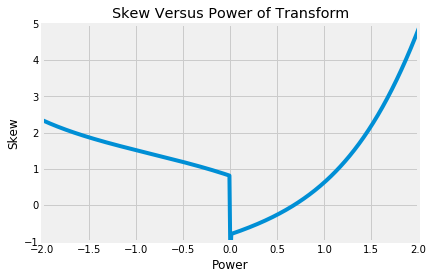

In [102]:
power=np.arange(-2,4,.01)
skew=[]

for k in np.arange(-2,4,.01):
    skew.append(stats.skew(df['desLength'].apply(lambda x: x**k)))
    
skew_min=sorted(zip(power,np.array(skew)**2),key=(lambda x: x[1]))[0]

plt.plot(power,skew)
plt.xlabel('Power')
plt.ylabel('Skew')
plt.xlim(-2,2)
plt.ylim(-1,5)
plt.title("Skew Versus Power of Transform")
plt.show()

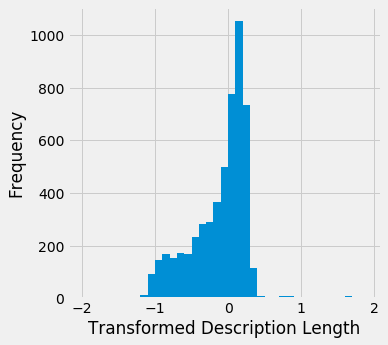

In [461]:
def transform(x):
    return x**skew_min[0]

plt.hist(df['desLength'].apply(transform).apply(lambda x: (x-30)/10),bins=np.arange(-2,2,.1))
plt.xlabel("Transformed Description Length")
plt.ylabel("Frequency")
plt.show()

In [462]:
skew_min

(0.6800000000000024, 1.0407190911647973e-05)

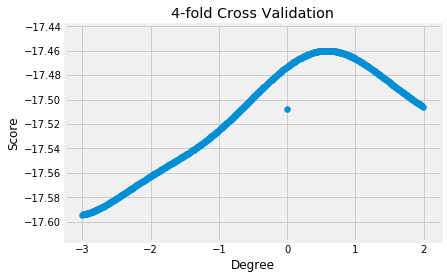

In [150]:
quad_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
skew_acc=[]
adj_r2=[]
for p in np.arange(-3,2,.01):
    df_train['dL_transformed_unskew']=df_train['desLength'].apply(lambda x: x**p)
    df_skew=df_train.drop(['desLength'],axis=1)
    x_skew=df_train[['stars','pics','descriptors','dL_transformed_unskew']]
    fit_skew=quad_lr.fit(x_skew,y_train)
    adj_r2.append(R2_adj(y_train,fit_skew.predict(x_skew),4))
    scores = cross_val_score(quad_lr, x_skew, y_train, cv=4, scoring='mean_squared_error')
    skew_acc.append((p,np.mean(scores)))
    
skew_x=[x[0] for x in skew_acc]
skew_y=[x[1] for x in skew_acc]


plt.scatter(skew_x, skew_y)
plt.title('4-fold Cross Validation')
plt.xlabel('Degree')
plt.ylabel("Score")
plt.show()

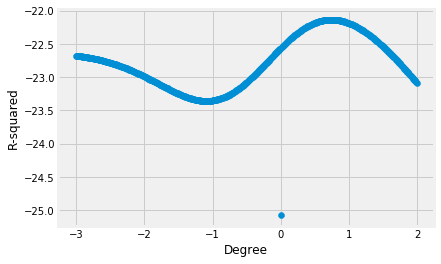

In [151]:
plt.scatter(skew_x, adj_r2)
plt.xlabel('Degree')
plt.ylabel("R-squared")
plt.show()

### Transforming to Gaussian

So indeed, the cross validated score and r-squared score are optimal near the place where the skew is minimal.  However, the score is still not very good.  We can go futher and make_ppf and make_cdf in order to convert the description length to gaussian.  We'll then fit the model and transform back in order to get the adjusted r-squared.

In [467]:
a=X_train['desLength']
vals = make_vals(a,1000)

def transform(x):
    return norm.ppf(make_cdf(vals,x))

def inv_transform(x):
    return make_ppf(a,norm.cdf(x,1))

In [483]:
X_tmp=pd.concat([X_transformed,y_train],axis=1)
X_tmp=X_tmp[abs(X_tmp.desLength_normal)<10]

X_train['desLength_normal'] = a.apply(transform)
X_tmp=pd.concat([X_transformed,y_train],axis=1)
X_tmp=X_tmp[abs(X_tmp.desLength_normal)<10]
xtdln=X_tmp.desLength_normal

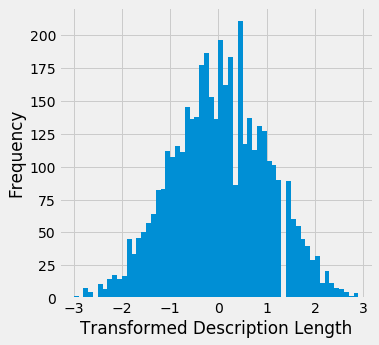

In [484]:
plt.hist(xtdln.values,bins=np.arange(-3,3,.1))
plt.xlabel("Transformed Description Length")
plt.ylabel("Frequency")
plt.show()

In [124]:
X_transformed2=X_tmp.iloc[:,:4]
y_train2=X_tmp.iloc[:,4:5]

So now we have a new column of transformed data. To get the inverse we need to reverse the steps, i.e, take the cdf of the gaussian distribution and then find the ppf using the make_ppf function.

In [388]:
results5=[]
for i in range(1,8):
    degree=i
    est = make_pipeline(StandardScaler(),PolynomialFeatures(degree), LinearRegression())
    fit5=est.fit(X_transformed2, y_train2)
    scores = cross_val_score(fit5, X_transformed2, y_train2, cv=4, scoring='mean_squared_error')
    y_predict=fit5.predict(X_transformed2)
    mse_adj=round(R2_adj(y_predict,y_train2,4),3)
    results5.append([i,round(fit5.score(X_transformed2,y_train2),3),round(np.mean(scores),2),mse_adj])
    print(f"Degree: {i},   Naive Score: {round(fit5.score(X_transformed2,y_train2),3)},  Cross_Val: {round(np.mean(scores),3)},   Adj R2: {mse_adj}")
    

Degree: 1,   Naive Score: 0.032,  Cross_Val: -17.511,   Adj R2: 0.031
Degree: 2,   Naive Score: 0.042,  Cross_Val: -17.446,   Adj R2: 0.041
Degree: 3,   Naive Score: 0.054,  Cross_Val: -17.537,   Adj R2: 0.053
Degree: 4,   Naive Score: 0.068,  Cross_Val: -18.15,   Adj R2: 0.067
Degree: 5,   Naive Score: 0.093,  Cross_Val: -31.452,   Adj R2: 0.092
Degree: 6,   Naive Score: 0.119,  Cross_Val: -353.296,   Adj R2: 0.118
Degree: 7,   Naive Score: 0.167,  Cross_Val: -980413.974,   Adj R2: 0.167


We are again running up against the .041 barrier. However, the Cross_Val score decays less rapidly around the optimal degree of 2.  This is our winning model up to this point.

## Model VI: Dropping Large Influence Points.

Let's look at the high-impact points in our transformed data.  Our metric for impact is givn by Cook's model.

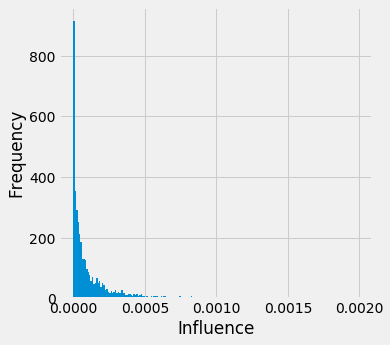

In [354]:
model_fit=sm.OLS(y_train2, sm.add_constant(X_transformed2)).fit()
model_cooks=model_fit.get_influence().cooks_distance[0]

simple_model_fit=sm.OLS(y_train, sm.add_constant(X_train)).fit()
simple_model_cooks=simple_model_fit.get_influence().cooks_distance[0]

plt.hist(model_cooks,bins=np.arange(0,.002,.00001))
plt.xlabel("Influence")
plt.ylabel("Frequency")
plt.show()

In [389]:
max(simple_model_cooks)

0.045815986925578776

In [365]:
df_small=pd.concat([pd.DataFrame(X_transformed2,columns=["stars","pics","descriptors","desLength_normal"]),y_train2],axis=1)
df_simp_train=pd.concat([pd.DataFrame(X_train,columns=["stars","pics","descriptors","desLength"]),y_train],axis=1)


df_small['leverage']=model_cooks
df_simp_train['leverage']=simple_model_cooks
df_small2=df_small[df_small.leverage<.00075]
df_small3=df_small.drop(['leverage'],axis=1)


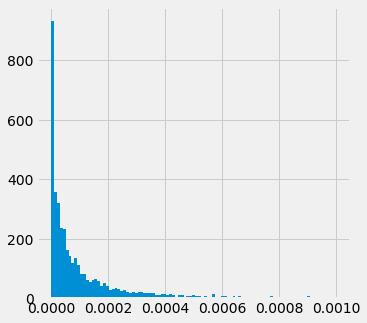

In [369]:
plt.hist(simple_model_cooks,bins=np.linspace(0,.001,100))
plt.show()

In [161]:
x_small=df_small3.iloc[:,:4]
y_small=df_small3.iloc[:,4:5]

results6=[]
for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    fit6=est.fit(x_small, y_small)
    scores = cross_val_score(fit6, x_small, y_small, cv=4, scoring='mean_squared_error')
    y_small_predict=fit6.predict(x_small)
    mse_adj=round(R2_adj(y_small_predict,y_small,4),3)
    results6.append([i,round(fit6.score(x_small,y_small),3),round(np.mean(scores),2),mse_adj])
    print(f"Degree: {i},   Naive Score: {round(fit6.score(x_small,y_small),3)},  Cross_Val: {round(np.mean(scores),3)},   Adj R2: {mse_adj}")
    

Degree: 1,   Naive Score: 0.032,  Cross_Val: -17.511,   Adj R2: 0.031
Degree: 2,   Naive Score: 0.042,  Cross_Val: -17.446,   Adj R2: 0.041
Degree: 3,   Naive Score: 0.054,  Cross_Val: -17.537,   Adj R2: 0.053
Degree: 4,   Naive Score: 0.068,  Cross_Val: -18.15,   Adj R2: 0.067
Degree: 5,   Naive Score: 0.093,  Cross_Val: -31.452,   Adj R2: 0.092
Degree: 6,   Naive Score: 0.119,  Cross_Val: -353.296,   Adj R2: 0.118
Degree: 7,   Naive Score: 0.167,  Cross_Val: -27617795.369,   Adj R2: 0.166


Ok, the quadratic model is still winning.  Let's do a final scan over the number of terms dropped.

In [373]:
df_tmp=df_simp_train[df_simp_train.leverage<.0004]
df_tmp2=df_tmp.drop(['leverage'],axis=1)

In [375]:
lst=np.linspace(.00001,.001,100)
quad = make_pipeline(StandardScaler(),PolynomialFeatures(2), LinearRegression())
simple_quad_scores=[]

for x in lst:
    df_tmp=df_simp_train[df_simp_train.leverage<x]
    df_tmp2=df_tmp.drop(['leverage'],axis=1)
    n=len(df_tmp2)
    x_simp=df_tmp2.iloc[:,:4]
    y_simp=df_tmp2.iloc[:,4:5]
    fit_simp=quad.fit(x_simp, y_simp)
    y_simp_predict=fit_simp.predict(x_simp)
    mse_adj=round(R2_adj(y_simp_predict,y_simp,4),3)
    score = cross_val_score(fit_simp, x_simp, y_simp, cv=4, scoring='mean_squared_error')
    simple_quad_scores.append([x,round(fit_simp.score(x_simp,y_simp),3),round(np.mean(score),2),mse_adj,n])


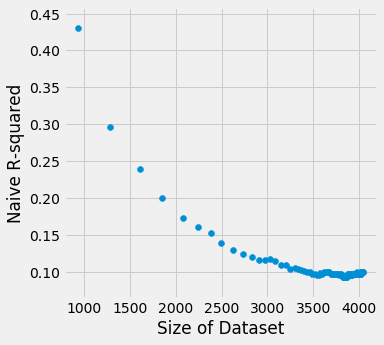

In [376]:
naive=[x[1] for x in simple_quad_scores]
cross_val=[x[2] for x in simple_quad_scores]
r2adj=[x[3] for x in simple_quad_scores]
size=[x[4] for x in simple_quad_scores]
plt.scatter(size,naive)
plt.xlabel("Size of Dataset")
plt.ylabel("Naive R-squared")
plt.show()

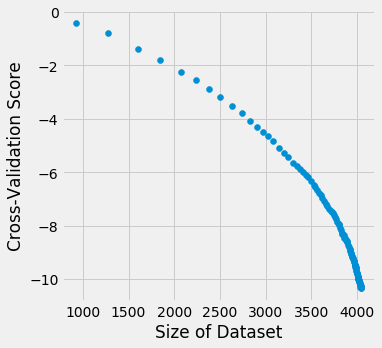

In [377]:
plt.scatter(size,cross_val)
plt.xlabel("Size of Dataset")
plt.ylabel("Cross-Validation Score")
plt.show()

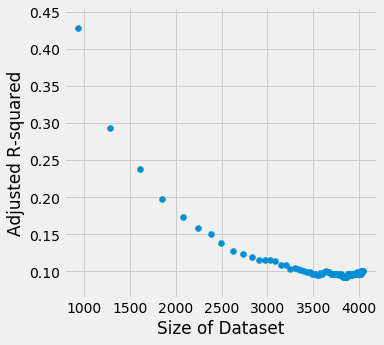

In [378]:
plt.scatter(size,r2adj)
plt.ylabel("Adjusted R-squared")
plt.xlabel("Size of Dataset")
plt.show()

In [56]:
lst=np.linspace(.00001,.00075,100)
quad = make_pipeline(PolynomialFeatures(2), LinearRegression())
quad_scores=[]
for x in lst:
    df_small_tmp=df_small[df_small.leverage<x]
    n=len(df_small_tmp)
    x_small=df_small_tmp.iloc[:,:4]
    y_small=df_small_tmp.iloc[:,4:5]
    fit6v2=quad.fit(x_small, y_small)
    y_small_predict=fit6v2.predict(x_small)
    mse_adj=round(R2_adj(y_small_predict,y_small,4),3)
    score = cross_val_score(fit6v2, x_small, y_small, cv=4, scoring='mean_squared_error')
    quad_scores.append([x,round(fit6v2.score(x_small,y_small),3),round(np.mean(score),2),mse_adj,n])


NameError: name 'df_small' is not defined

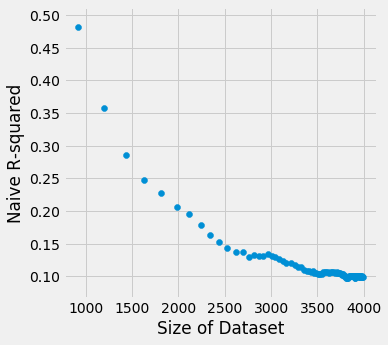

In [271]:
naive=[x[1] for x in quad_scores]
cross_val=[x[2] for x in quad_scores]
r2adj=[x[3] for x in quad_scores]
size=[x[4] for x in quad_scores]
plt.scatter(size,naive)
plt.xlabel("Size of Dataset")
plt.ylabel("Naive R-squared")
plt.show()

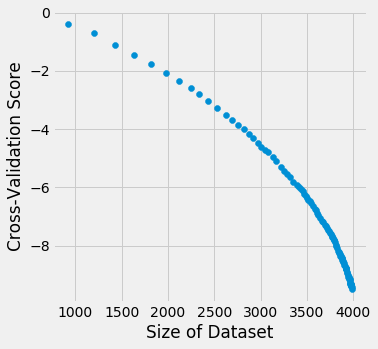

In [272]:
plt.scatter(size,cross_val)
plt.xlabel("Size of Dataset")
plt.ylabel("Cross-Validation Score")
plt.show()

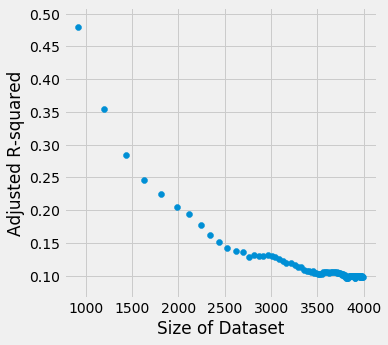

In [273]:
plt.scatter(size,r2adj)
plt.ylabel("Adjusted R-squared")
plt.xlabel("Size of Dataset")
plt.show()

Interestingly, the model gets better the more we drop data!!!.  Will the same pattern hold if we drop the low influence data?

In [260]:
quad_scores_droplow=[]
for x in lst:
    df_small_dl=df_small[df_small.leverage>x]
    n=len(df_small_dl)
    x_small_dl=df_small_dl.iloc[:,:4]
    y_small_dl=df_small_dl.iloc[:,4:5]
    fit6v2_dl=quad.fit(x_small_dl, y_small_dl)
    y_small_predict_dl=fit6v2.predict(x_small_dl)
    mse_adj=round(R2_adj(y_small_predict_dl,y_small_dl,4),3)
    score = cross_val_score(fit6v2_dl, x_small_dl, y_small_dl, cv=4, scoring='mean_squared_error')
    quad_scores_droplow.append([x,round(fit6v2.score(x_small_dl,y_small_dl),3),round(np.mean(score),2),mse_adj,n])

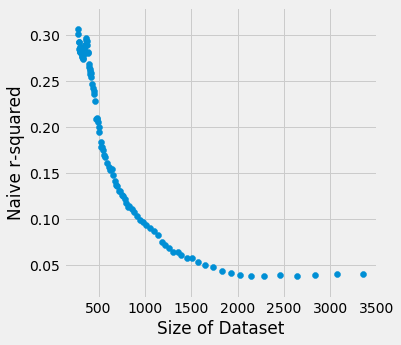

In [274]:
naive_droplow=[x[1] for x in quad_scores_droplow]
cross_val_droplow=[x[2] for x in quad_scores_droplow]
r2adj_droplow=[x[3] for x in quad_scores_droplow]
size_dl=[x[4] for x in quad_scores_droplow]
plt.scatter(size_dl,naive_droplow)
plt.xlabel("Size of Dataset")
plt.ylabel("Naive r-squared")
plt.show()

This plot is sloping in the opposite direction as the previous one, but in both there is an anti-correlation between the naive r-squared metric and the amount of data.

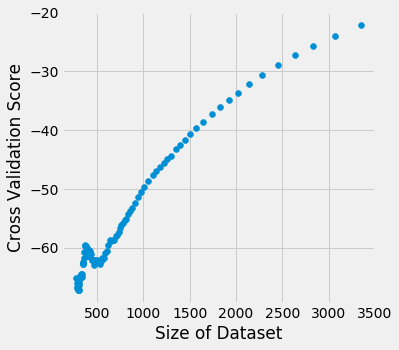

In [276]:
plt.scatter(size_dl,cross_val_droplow)
plt.xlabel("Size of Dataset")
plt.ylabel("Cross Validation Score")
plt.show()

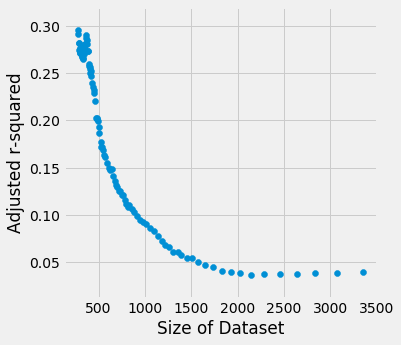

In [277]:
plt.scatter(size_dl,r2adj_droplow)
plt.xlabel("Size of Dataset")
plt.ylabel("Adjusted r-squared")
plt.show()

In [289]:
lst_fin=np.linspace(.0000001,.00005,100)
quad_scores_fin=[]
for x in lst_fin:
    df_small_tmp=df_small[df_small.leverage<x]
    n=len(df_small_tmp)
    x_small=df_small_tmp.iloc[:,:4]
    y_small=df_small_tmp.iloc[:,4:5]
    fit6v2=quad.fit(x_small, y_small)
    y_small_predict=fit6v2.predict(x_small)
    mse_adj=round(R2_adj(y_small_predict,y_small,4),3)
    score = cross_val_score(fit6v2, x_small, y_small, cv=10, scoring='mean_squared_error')
    quad_scores_fin.append([x,round(fit6v2.score(x_small,y_small),3),round(np.mean(score),2),mse_adj,n])


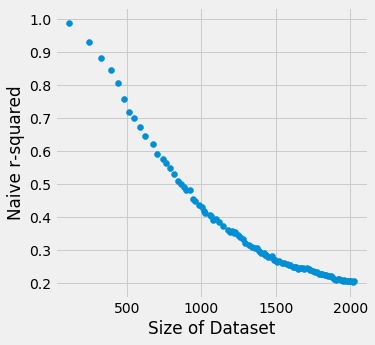

In [290]:
naive_fin=[x[1] for x in quad_scores_fin]
cross_val_fin=[x[2] for x in quad_scores_fin]
r2adj_fin=[x[3] for x in quad_scores_fin]
size_fin=[x[4] for x in quad_scores_fin]
plt.scatter(size_fin,naive_fin)
plt.xlabel("Size of Dataset")
plt.ylabel("Naive r-squared")
plt.show()

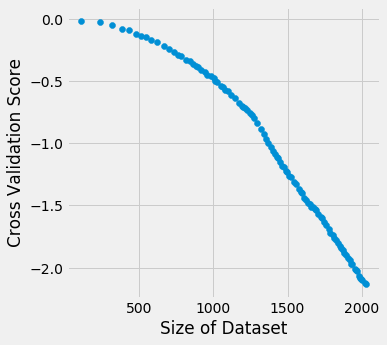

In [291]:
plt.scatter(size_fin,cross_val_fin)
plt.xlabel("Size of Dataset")
plt.ylabel("Cross Validation Score")
plt.show()

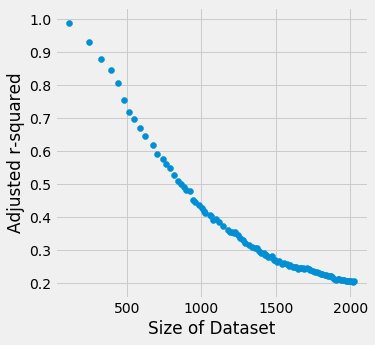

In [292]:
plt.scatter(size_fin,r2adj_fin)
plt.xlabel("Size of Dataset")
plt.ylabel("Adjusted r-squared")
plt.show()

## Model VII: Random Forest Regressor

In [394]:
model7=RandomForestRegressor(n_estimators=5)

results7=get_model_stats(X_train,y_train,modelx,7)

Degree: 1,   Naive Score: 0.645,  Cross_Val: -22.96,   MSE: 0.645
Degree: 2,   Naive Score: 0.654,  Cross_Val: -22.46,   MSE: 0.654
Degree: 3,   Naive Score: 0.668,  Cross_Val: -21.87,   MSE: 0.668
Degree: 4,   Naive Score: 0.662,  Cross_Val: -22.18,   MSE: 0.662
Degree: 5,   Naive Score: 0.667,  Cross_Val: -22.8,   MSE: 0.667
Degree: 6,   Naive Score: 0.669,  Cross_Val: -22.15,   MSE: 0.669
Degree: 7,   Naive Score: 0.655,  Cross_Val: -22.46,   MSE: 0.655


RandomForest is awesome.  The Cross-Val scores are steady, indicating good generalizability.  The MSE has improved by a factor of 15.  It also appears that the third order polynomials are the best with this method.  Let's do a grid search to optimize.

In [153]:
param_dict={'n_estimators':np.array(range(1,21,1))}
GSCV=GridSearchCV(RandomForestRegressor(),param_dict)
GSCV.fit(X_train,y_train)
gscv_model=GSCV.best_estimator_

In [439]:
GSCV.best_params_

{'n_estimators': 19}

In [440]:
GSCV.cv_results_['mean_test_score'][18]

-0.1551734267619059

In [422]:
y_gscv_predict=gscv_model.predict(X_train)
R2_adj(y_train.values,y_gscv_predict,4)[0]

0.4390878964874354

## Model VIII: Gradient Boosting Regressor

In [486]:
from sklearn.ensemble import GradientBoostingRegressor

model8 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls')

fit8=model8.fit(X_train,y_train)

results8=get_model_stats(X_train,y_train,model8,4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# Test Data Comparison

We are now ready to look at test data.

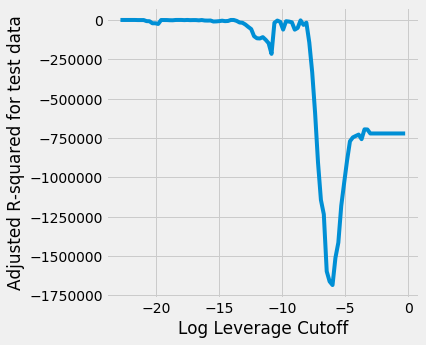

In [320]:
new_list=np.array([10**(-i/10) for i in range(1,100,1)])
r2_test=[]
for x in new_list:
    df_small_tmp=df_small[df_small.leverage<x]
    x_small=df_small_tmp.iloc[:,:4]
    y_small=df_small_tmp.iloc[:,4:5]
    fit_final=quad.fit(x_small, y_small)
    y_test_predict_fin = fit_final.predict(X_test)
    r2_test.append(R2_adj(y_test_predict_fin,y_test,4))

plt.plot(np.log(new_list),r2_test)
plt.xlabel("Log Leverage Cutoff")
plt.ylabel("Adjusted R-squared for test data")
plt.show()

In [322]:
fit5=quad.fit(X_transformed2, y_train2)

y_test_predict_model5=fit5.predict(X_test)
R2_adj(y_test_predict_model5,y_test,4)

-721314.9652566466

In [65]:
quad = make_pipeline(PolynomialFeatures(2), Lasso(10**(-9)))

In [68]:
acc3=[]
for a in alphas:
    quad = make_pipeline(PolynomialFeatures(2), Lasso(a))
    fit1=quad.fit(X_train, y_train)

    y_test_predict_model1=fit1.predict(X_test)
    acc3.append(R2_adj(y_test_predict_model1,y_test,14))

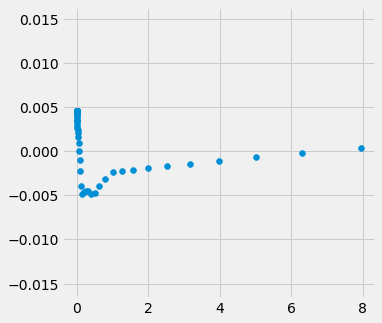

In [70]:
plt.scatter(alphas,acc3)

In [443]:
y_gscv_test=gscv_model.predict(X_test)
R2(y_gscv_test,y_test)[0]

-0.08583521586480702

In [155]:
y_gscv_test=gscv_model.predict(X_test)
R2_adj(y_gscv_test,y_test,4)

-0.08779002255101442

# Conclusions

After a semi-thorough analysis, it appears that the simple quadratic model is actually the best!  